In [ ]:
!pip install requirements.txt

In [26]:
%load_ext autoreload
%autoreload 2

from flask import Flask
from flask.helpers import get_root_path

from jupyter_dash import JupyterDash
from dash_app.layout import layout
from dash_app.callbacks import register_callbacks

app = JupyterDash(__name__, #server=server,
                  url_base_pathname='/',
                  assets_folder='dash_app/assets/')

app.title = 'Gait Analyzer'
app.layout = layout
register_callbacks(app)

# Run app and display result inline in the notebook
app.run_server(mode='inline', debug=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from plotly.subplots import make_subplots
fig = make_subplots(2, 1, shared_xaxes=True)
for i, n in enumerate(['r_knee_flex', 'l_knee_flex']):
    fig.add_trace(go.Scatter(y=angles[n], name=n), i+1, 1)
fig.update_yaxes(matches='y')
fig.update_layout(dragmode= 'pan', xaxis=dict(range=[0,300]), yaxis=dict(range=[120,190], fixedrange=True))
fig.add_shape(
    dict(type="line", x0=20, x1=20, y0=120, y1=200, line_color="green"), row="all", col=1
)
fig.show()
#fig.update_shapes(dict(x0=30, x1=30))

NameError: name 'go' is not defined

In [57]:
#%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from data.gait_cycle_detector import GaitCycleDetector
from data.video import Video
from model.mediapipe_estimator import MediaPipe_Estimator2D
from data.skeleton_helper import MediaPipeSkeleton

def get_knee_angle(pose_2d, a, b, c):
    p_BA = pose_2d[:, a] - pose_2d[:, b]
    p_BC = pose_2d[:, c] - pose_2d[:, b]
    dot_products = np.sum(p_BA*p_BC,axis=1)
    norm_products = np.linalg.norm(p_BA,axis=1)*np.linalg.norm(p_BC,axis=1)
    return np.rad2deg(np.arccos(dot_products/norm_products))


estimator = MediaPipe_Estimator2D(out_format='mediapipe')
video = Video('dash_app/assets/demo.mp4')
pose_2d, meta = estimator.estimate(video)
pose_2d = pose_2d['video']['custom'][0]

gcd = GaitCycleDetector()
mins, maxs = gcd.simple_detection(pose_2d)

joint_idx = MediaPipeSkeleton().keypoint2index
knee_angle = get_knee_angle(pose_2d, joint_idx['left_hip'], joint_idx['left_knee'], joint_idx['left_ankle'])

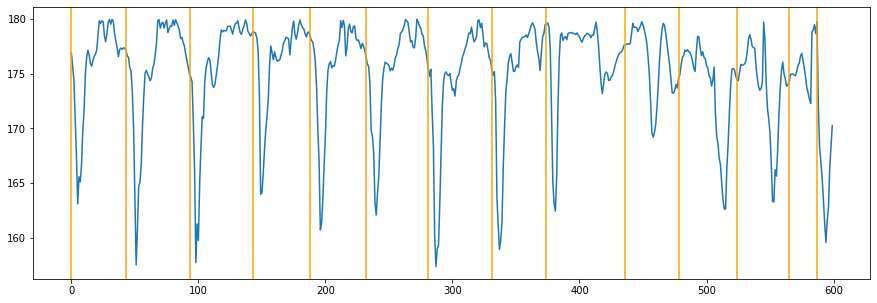

In [58]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(knee_angle)
for mm in maxs.tolist():
    plt.axvline(x=mm[0], color="orange")
plt.show()